In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import warnings

warnings.filterwarnings("ignore")

# === Загрузка и предобработка файла MTSS ===
mtss_raw = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/mtss_candles.csv")
mtss = mtss_raw[["begin", "close"]].copy()
mtss["Date"] = pd.to_datetime(mtss["begin"]).dt.date
mtss = mtss.rename(columns={"close": "Stock Close"}).drop(columns=["begin"])
mtss = mtss.groupby("Date").first().reset_index()
mtss["Date"] = pd.to_datetime(mtss["Date"])
mtss.set_index("Date", inplace=True)

# === Функции ===
def load_and_prepare(file_path, date_col, value_col, skip_rows=0, date_format=None):
    df = pd.read_csv(file_path, skiprows=skip_rows)
    df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[[value_col]]

def process_non_standard_file(file_path, date_col, value_col):
    df = pd.read_csv(file_path, skiprows=2)
    df.columns = [date_col, value_col, 'High', 'Low', 'Open', 'Volume']
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[[value_col]]

def process_vix_file(file_path):
    df = pd.read_csv(file_path, skiprows=2)
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df.set_index('Date', inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[['Close']].rename(columns={'Close': 'VIX'})

# === Пути к данным ===
file_paths = {
    "imoex": "C:/Users/Matvey/Desktop/Диплом/imoex_candles.csv",
    "rtsi": "C:/Users/Matvey/Desktop/Диплом/rtsi_candles.csv",
    "vix": "C:/Users/Matvey/Desktop/Диплом/vix_data.csv",
    "gvz": "C:/Users/Matvey/Desktop/Диплом/gvz_data.csv",
    "gold": "C:/Users/Matvey/Desktop/Диплом/gold_data.csv",
    "oil": "C:/Users/Matvey/Desktop/Диплом/oil_data.csv",
    "moexog": "C:/Users/Matvey/Desktop/Диплом/moexog_candles.csv",
    "rgbi": "C:/Users/Matvey/Desktop/Диплом/rgbi_candles.csv",
    "macro": "C:/Users/Matvey/Desktop/Диплом/macroeconomic_data.csv"
}

# === Загрузка экзогенных переменных ===
imoex = load_and_prepare(file_paths["imoex"], "begin", "close").rename(columns={"close": "IMOEX Close"})
rtsi = load_and_prepare(file_paths["rtsi"], "begin", "close").rename(columns={"close": "RTSI Close"})
moexog = load_and_prepare(file_paths["moexog"], "begin", "close").rename(columns={"close": "MOEXOG Close"})
rgbi = load_and_prepare(file_paths["rgbi"], "begin", "close").rename(columns={"close": "RGBI Close"})
vix = process_vix_file(file_paths["vix"])
gvz = process_non_standard_file(file_paths["gvz"], "Date", "Close").rename(columns={"Close": "GVZ"})
gold = process_non_standard_file(file_paths["gold"], "Date", "Close").rename(columns={"Close": "Gold Price"})
oil = process_non_standard_file(file_paths["oil"], "Date", "Close").rename(columns={"Close": "Oil Price"})

# === Макроэкономика ===
macro_df = pd.read_csv(file_paths["macro"])
macro_df['date'] = pd.to_datetime(macro_df['date'], errors='coerce')
macro_df = macro_df.dropna(subset=['date'])
macro_df.set_index('date', inplace=True)
macro_df = macro_df[~macro_df.index.duplicated(keep='first')]
macro_df = macro_df[['inflation', 'key_rate', 'usd_rate', 'cny_rate']]
macro_df.columns = ['Inflation', 'Key Rate', 'USD Rate', 'CNY Rate']
macro_df = macro_df.resample('D').interpolate()

# === Объединение всех данных ===
merged_data = pd.concat(
    [mtss, imoex, rtsi, moexog, rgbi, vix, gvz, gold, oil, macro_df],
    axis=1
)

# === Заполнение пропусков ===
merged_data = merged_data.interpolate(method='linear')
merged_data = merged_data[::-1].ffill()[::-1]

# === Сброс индекса и сохранение с колонкой "Date" ===
merged_data = merged_data.reset_index().rename(columns={"index": "Date"})
output_path = "C:/Users/Matvey/Desktop/Диплом/mtss_merged_data.csv"
merged_data.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"✅ Данные успешно сохранены в: {output_path}")
# Просмотр первых строк
display(merged_data.head())


✅ Данные успешно сохранены в: C:/Users/Matvey/Desktop/Диплом/mtss_merged_data.csv


,Date,Stock Close,IMOEX Close,RTSI Close,MOEXOG Close,RGBI Close,VIX,GVZ,Gold Price,Oil Price,Inflation,Key Rate,USD Rate,CNY Rate
0,2015-01-01,334.9,1435.66,761.3,3640.27,104.98,17.790001,20.230000,1186.000000,56.419998,68.368100,56.237600,60.85,10.916
1,2015-01-02,334.9,1435.66,761.3,3640.27,104.98,17.790001,20.230000,1186.000000,56.419998,68.867017,56.779158,60.85,10.916
2,2015-01-03,334.9,1435.66,761.3,3640.27,104.98,18.500001,20.573333,1191.966675,55.316666,69.365933,57.320717,60.85,10.916
3,2015-01-04,334.9,1435.66,761.3,3640.27,104.98,19.210000,20.916667,1197.933350,54.213333,69.864850,57.862275,60.85,10.916
4,2015-01-05,334.9,1435.66,761.3,3640.27,104.98,19.920000,21.260000,1203.900024,53.110001,70.363767,58.403833,60.85,10.916


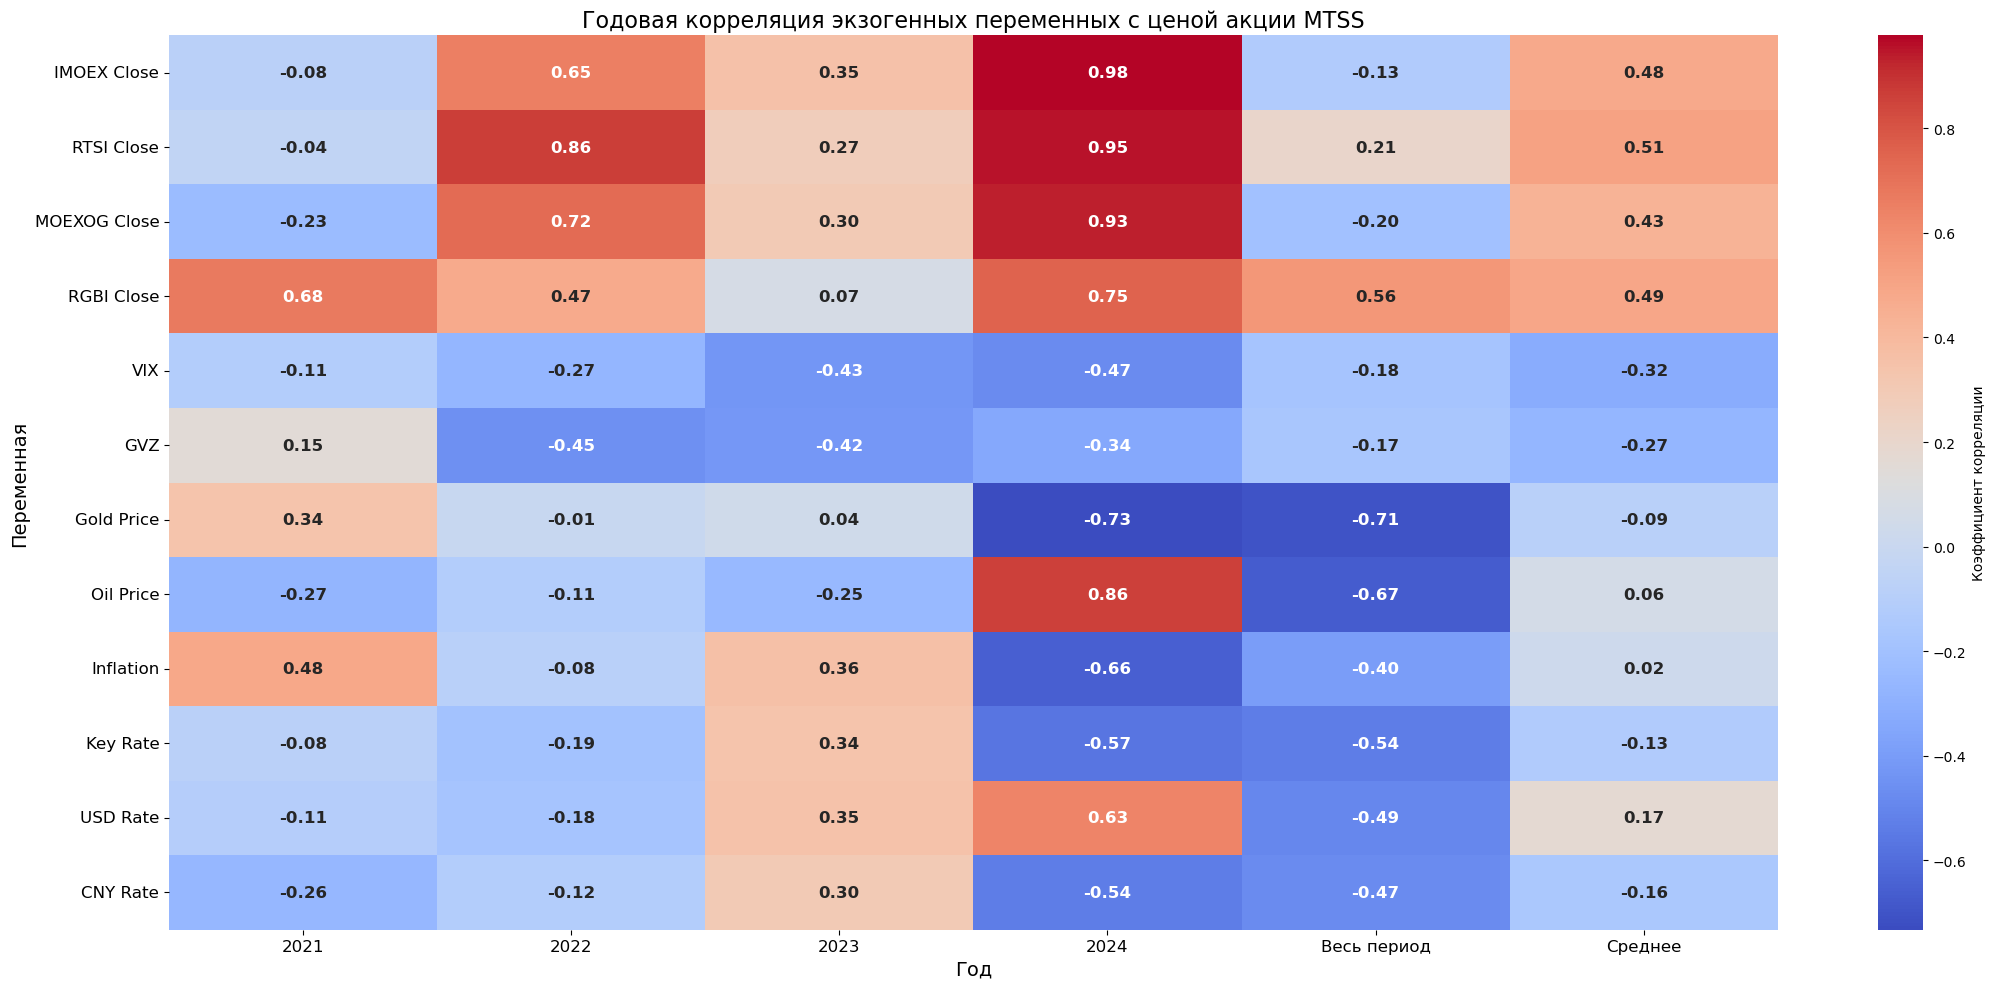

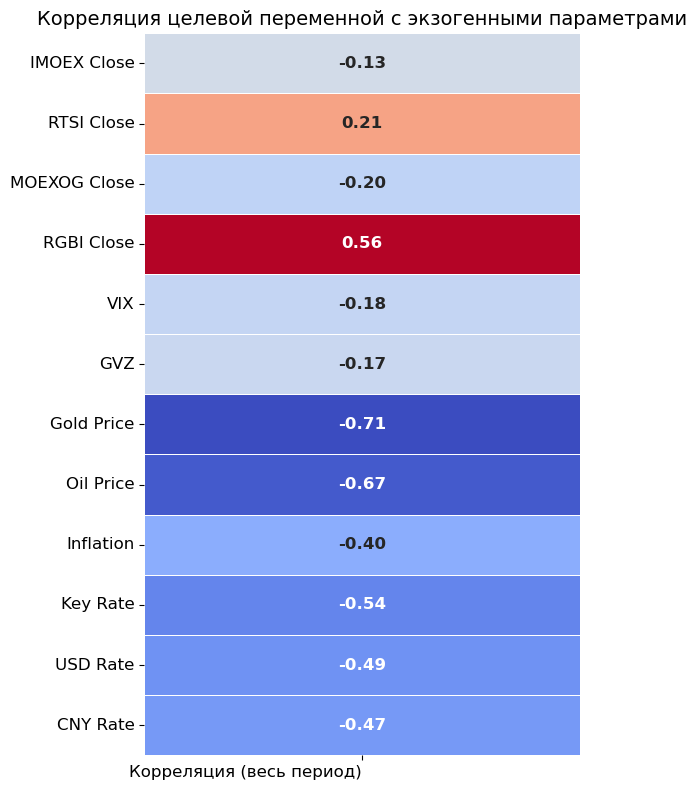

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Загрузка объединённых данных ===
merged_data = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/mtss_merged_data.csv")
merged_data["Date"] = pd.to_datetime(merged_data["Date"])
merged_data.set_index("Date", inplace=True)

# --- Годовые корреляции ---
years = range(2021, 2025)
yearly_corrs = {}

for year in years:
    yearly_df = merged_data[merged_data.index.year == year]
    if not yearly_df.empty:
        corr = yearly_df.corr(numeric_only=True)
        yearly_corrs[str(year)] = corr["Stock Close"].drop("Stock Close", errors="ignore")

# Корреляции за весь период
corr_all_period = merged_data.corr(numeric_only=True)["Stock Close"].drop("Stock Close", errors="ignore")
yearly_corrs["Весь период"] = corr_all_period

# Сводная таблица
corr_by_year_df = pd.DataFrame(yearly_corrs)
years_only = [str(year) for year in years if str(year) in corr_by_year_df.columns]
corr_by_year_df["Среднее"] = corr_by_year_df[years_only].mean(axis=1)

# --- Визуализация ---
plt.figure(figsize=(22, 10))
sns.heatmap(
    corr_by_year_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar_kws={'label': 'Коэффициент корреляции'},
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title("Годовая корреляция экзогенных переменных с ценой акции MTSS", fontsize=16)
plt.xlabel("Год", fontsize=14)
plt.ylabel("Переменная", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# --- Корреляции за весь период (отдельно) ---
merged_data.reset_index(inplace=True)
data_for_corr = merged_data.drop(columns=["Date"], errors="ignore")
corr_all_period = data_for_corr.corr()["Stock Close"].drop("Stock Close", errors="ignore")

corr_df = pd.DataFrame(corr_all_period)
corr_df.columns = ["Корреляция (весь период)"]

plt.figure(figsize=(6, 8))
sns.heatmap(
    corr_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar=False,
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title("Корреляция целевой переменной с экзогенными параметрами", fontsize=14)
plt.xticks(fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


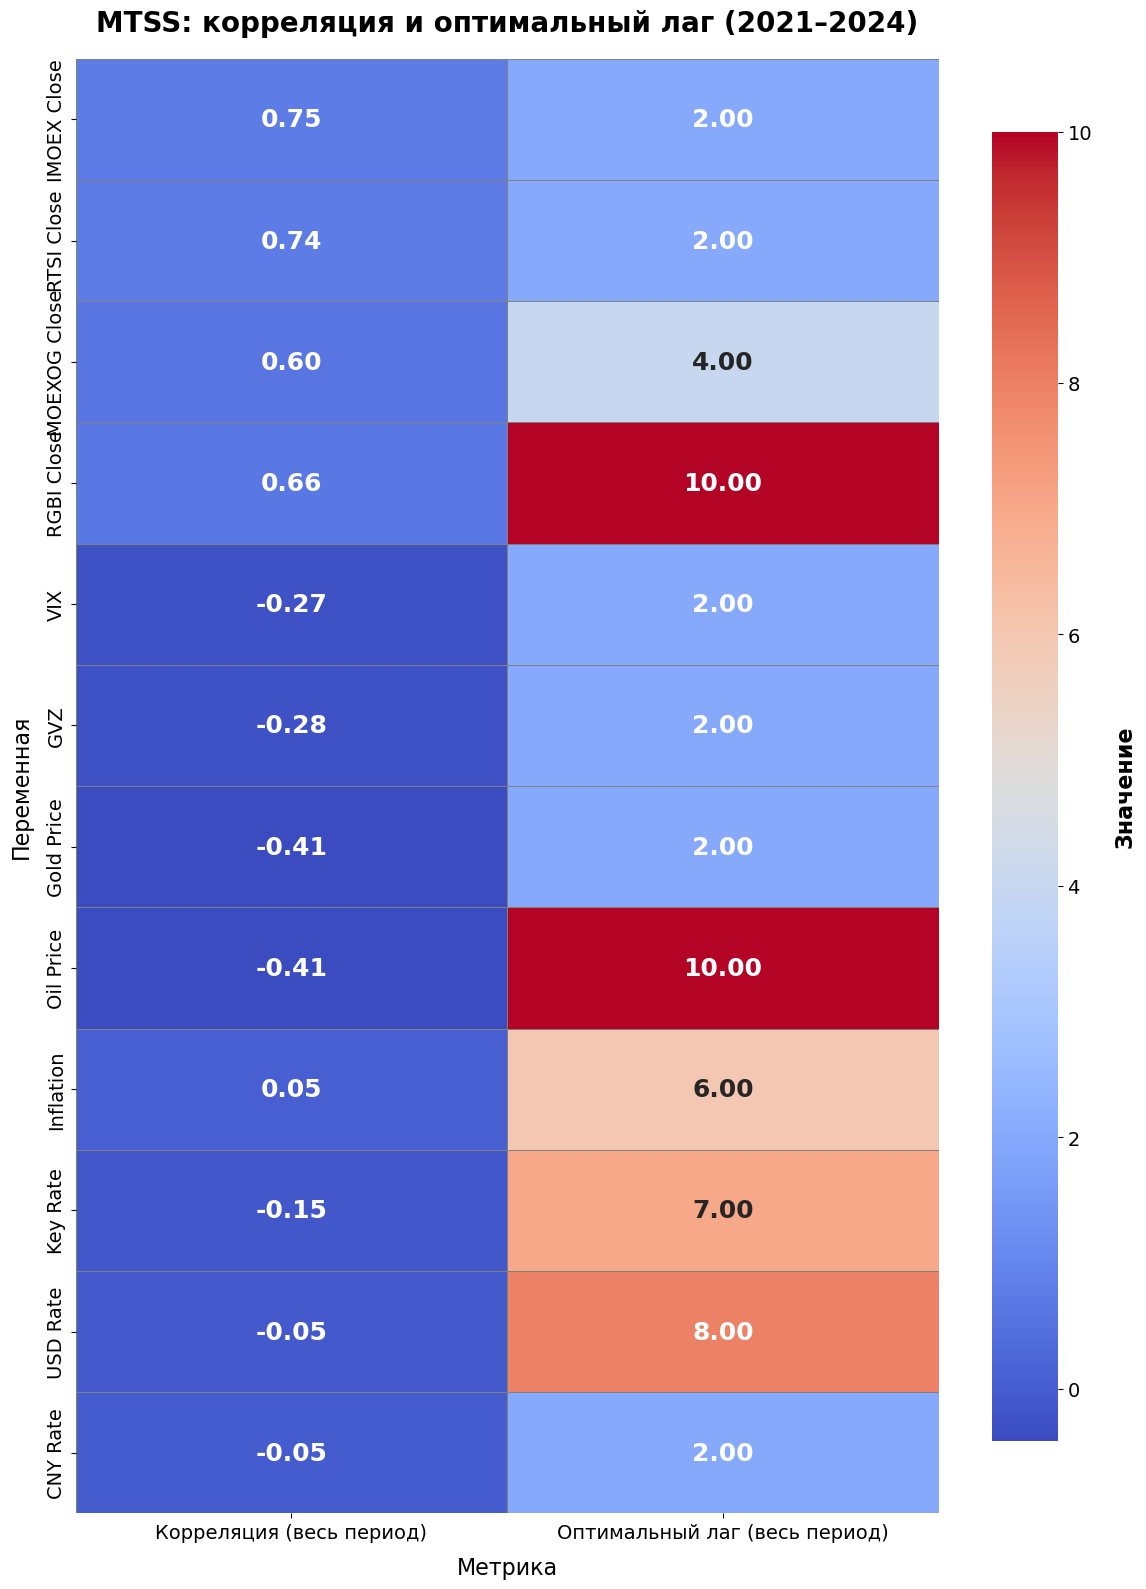

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
import warnings

warnings.filterwarnings('ignore')

# === Загрузка и подготовка данных ===
df = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/mtss_merged_data.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]

# === Настройка переменных ===
target = 'Stock Close'
best_features = [col for col in df.columns if col != target]

df[best_features] = df[best_features].interpolate().ffill()
df.dropna(inplace=True)

# === Годовые корреляции ===
years = [2021, 2022, 2023, 2024]
corr_by_year = {}

for year in years:
    df_year = df[df.index.year == year]
    corr = df_year.corr()
    corr_by_year[str(year)] = corr[target].drop(target)

corr_total = df.corr()
corr_by_year["Весь период"] = corr_total[target].drop(target)

corr_by_year_df = pd.DataFrame(corr_by_year)

# === Расчёт оптимальных лагов (Грейнджер) ===
lags_total = {}
for feature in best_features:
    try:
        test_result = grangercausalitytests(df[[target, feature]].dropna(), maxlag=10, verbose=False)
        p_values = [test_result[i+1][0]['ssr_ftest'][1] for i in range(10)]
        optimal_lag = np.argmin(p_values) + 1
        lags_total[feature] = optimal_lag
    except Exception:
        lags_total[feature] = np.nan

lags_total_series = pd.Series(lags_total, name="Оптимальный лаг (весь период)")
corr_total_series = corr_by_year_df["Весь период"]

arimax_total_selection = pd.concat([corr_total_series, lags_total_series], axis=1)
arimax_total_selection.columns = ["Корреляция (весь период)", "Оптимальный лаг (весь период)"]

# === Визуализация ===
plt.figure(figsize=(12, 16))
heatmap = sns.heatmap(
    arimax_total_selection,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.6,
    linecolor="gray",
    annot_kws={"size": 18, "weight": "bold"},
    cbar_kws={"label": "Значение", "shrink": 0.9}
)
plt.title("MTSS: корреляция и оптимальный лаг (2021–2024)", fontsize=20, fontweight="bold", pad=20)
plt.xlabel("Метрика", fontsize=16, labelpad=10)
plt.ylabel("Переменная", fontsize=16, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplots_adjust(left=0.3)
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label("Значение", fontsize=16, weight="bold", labelpad=15)
plt.tight_layout()
plt.show()


🔄 Rolling forecast начат...


Прогнозирование:   0%|                                                                        | 0/182 [00:00<?, ?шаг/s]

📍 Итерация 0-2 | Дата: 2024-01-02


Прогнозирование:   1%|▎                                                               | 1/182 [00:02<08:41,  2.88s/шаг]

📍 Итерация 2-4 | Дата: 2024-01-04


Прогнозирование:   1%|▋                                                               | 2/182 [00:06<09:29,  3.17s/шаг]

📍 Итерация 4-6 | Дата: 2024-01-06


Прогнозирование:   2%|█                                                               | 3/182 [00:09<10:01,  3.36s/шаг]

📍 Итерация 6-8 | Дата: 2024-01-08


Прогнозирование:   2%|█▍                                                              | 4/182 [00:12<09:12,  3.10s/шаг]

📍 Итерация 8-10 | Дата: 2024-01-10


Прогнозирование:   3%|█▊                                                              | 5/182 [00:16<09:34,  3.24s/шаг]

📍 Итерация 10-12 | Дата: 2024-01-12


Прогнозирование:   3%|██                                                              | 6/182 [00:18<09:08,  3.12s/шаг]

📍 Итерация 12-14 | Дата: 2024-01-14


Прогнозирование:   4%|██▍                                                             | 7/182 [00:21<08:56,  3.06s/шаг]

📍 Итерация 14-16 | Дата: 2024-01-16


Прогнозирование:   4%|██▊                                                             | 8/182 [00:24<08:44,  3.02s/шаг]

📍 Итерация 16-18 | Дата: 2024-01-18


Прогнозирование:   5%|███▏                                                            | 9/182 [00:27<08:47,  3.05s/шаг]

📍 Итерация 18-20 | Дата: 2024-01-20


Прогнозирование:   5%|███▍                                                           | 10/182 [00:31<08:46,  3.06s/шаг]

📍 Итерация 20-22 | Дата: 2024-01-22


Прогнозирование:   6%|███▊                                                           | 11/182 [00:34<09:10,  3.22s/шаг]

📍 Итерация 22-24 | Дата: 2024-01-24


Прогнозирование:   7%|████▏                                                          | 12/182 [00:37<09:14,  3.26s/шаг]

📍 Итерация 24-26 | Дата: 2024-01-26


Прогнозирование:   7%|████▌                                                          | 13/182 [00:41<09:31,  3.38s/шаг]

📍 Итерация 26-28 | Дата: 2024-01-28


Прогнозирование:   8%|████▊                                                          | 14/182 [00:45<09:51,  3.52s/шаг]

📍 Итерация 28-30 | Дата: 2024-01-30


Прогнозирование:   8%|█████▏                                                         | 15/182 [00:49<09:56,  3.57s/шаг]

📍 Итерация 30-32 | Дата: 2024-02-01


Прогнозирование:   9%|█████▌                                                         | 16/182 [00:52<09:46,  3.53s/шаг]

📍 Итерация 32-34 | Дата: 2024-02-03


Прогнозирование:   9%|█████▉                                                         | 17/182 [00:56<09:50,  3.58s/шаг]

📍 Итерация 34-36 | Дата: 2024-02-05


Прогнозирование:  10%|██████▏                                                        | 18/182 [00:59<09:44,  3.57s/шаг]

📍 Итерация 36-38 | Дата: 2024-02-07


Прогнозирование:  10%|██████▌                                                        | 19/182 [01:03<09:49,  3.62s/шаг]

📍 Итерация 38-40 | Дата: 2024-02-09


Прогнозирование:  11%|██████▉                                                        | 20/182 [01:06<09:27,  3.50s/шаг]

📍 Итерация 40-42 | Дата: 2024-02-11


Прогнозирование:  12%|███████▎                                                       | 21/182 [01:10<09:18,  3.47s/шаг]

📍 Итерация 42-44 | Дата: 2024-02-13


Прогнозирование:  12%|███████▌                                                       | 22/182 [01:13<09:06,  3.42s/шаг]

📍 Итерация 44-46 | Дата: 2024-02-15


Прогнозирование:  13%|███████▉                                                       | 23/182 [01:17<09:23,  3.54s/шаг]

📍 Итерация 46-48 | Дата: 2024-02-17


Прогнозирование:  13%|████████▎                                                      | 24/182 [01:20<08:57,  3.40s/шаг]

📍 Итерация 48-50 | Дата: 2024-02-19


Прогнозирование:  14%|████████▋                                                      | 25/182 [01:23<08:40,  3.32s/шаг]

📍 Итерация 50-52 | Дата: 2024-02-21


Прогнозирование:  14%|█████████                                                      | 26/182 [01:26<08:30,  3.27s/шаг]

📍 Итерация 52-54 | Дата: 2024-02-23


Прогнозирование:  15%|█████████▎                                                     | 27/182 [01:30<08:33,  3.31s/шаг]

📍 Итерация 54-56 | Дата: 2024-02-25


Прогнозирование:  15%|█████████▋                                                     | 28/182 [01:33<08:40,  3.38s/шаг]

📍 Итерация 56-58 | Дата: 2024-02-27


Прогнозирование:  16%|██████████                                                     | 29/182 [01:37<08:41,  3.41s/шаг]

📍 Итерация 58-60 | Дата: 2024-02-29


Прогнозирование:  16%|██████████▍                                                    | 30/182 [01:40<08:48,  3.48s/шаг]

📍 Итерация 60-62 | Дата: 2024-03-02


Прогнозирование:  17%|██████████▋                                                    | 31/182 [01:44<09:08,  3.63s/шаг]

📍 Итерация 62-64 | Дата: 2024-03-04


Прогнозирование:  18%|███████████                                                    | 32/182 [01:48<09:11,  3.67s/шаг]

📍 Итерация 64-66 | Дата: 2024-03-06


Прогнозирование:  18%|███████████▍                                                   | 33/182 [01:52<09:30,  3.83s/шаг]

📍 Итерация 66-68 | Дата: 2024-03-08


Прогнозирование:  19%|███████████▊                                                   | 34/182 [01:56<09:39,  3.92s/шаг]

📍 Итерация 68-70 | Дата: 2024-03-10


Прогнозирование:  19%|████████████                                                   | 35/182 [02:00<09:26,  3.85s/шаг]

📍 Итерация 70-72 | Дата: 2024-03-12


Прогнозирование:  20%|████████████▍                                                  | 36/182 [02:04<09:41,  3.98s/шаг]

📍 Итерация 72-74 | Дата: 2024-03-14


Прогнозирование:  20%|████████████▊                                                  | 37/182 [02:08<09:28,  3.92s/шаг]

📍 Итерация 74-76 | Дата: 2024-03-16


Прогнозирование:  21%|█████████████▏                                                 | 38/182 [02:12<09:22,  3.90s/шаг]

📍 Итерация 76-78 | Дата: 2024-03-18


Прогнозирование:  21%|█████████████▌                                                 | 39/182 [02:16<09:32,  4.00s/шаг]

📍 Итерация 78-80 | Дата: 2024-03-20


Прогнозирование:  22%|█████████████▊                                                 | 40/182 [02:20<09:12,  3.89s/шаг]

📍 Итерация 80-82 | Дата: 2024-03-22


Прогнозирование:  23%|██████████████▏                                                | 41/182 [02:24<09:03,  3.86s/шаг]

📍 Итерация 82-84 | Дата: 2024-03-24


Прогнозирование:  23%|██████████████▌                                                | 42/182 [02:27<08:58,  3.85s/шаг]

📍 Итерация 84-86 | Дата: 2024-03-26


Прогнозирование:  24%|██████████████▉                                                | 43/182 [02:31<08:44,  3.77s/шаг]

📍 Итерация 86-88 | Дата: 2024-03-28


Прогнозирование:  24%|███████████████▏                                               | 44/182 [02:34<08:22,  3.64s/шаг]

📍 Итерация 88-90 | Дата: 2024-03-30


Прогнозирование:  25%|███████████████▌                                               | 45/182 [02:37<07:55,  3.47s/шаг]

📍 Итерация 90-92 | Дата: 2024-04-01


Прогнозирование:  25%|███████████████▉                                               | 46/182 [02:40<07:35,  3.35s/шаг]

📍 Итерация 92-94 | Дата: 2024-04-03


Прогнозирование:  26%|████████████████▎                                              | 47/182 [02:44<07:21,  3.27s/шаг]

📍 Итерация 94-96 | Дата: 2024-04-05


Прогнозирование:  26%|████████████████▌                                              | 48/182 [02:47<07:09,  3.20s/шаг]

📍 Итерация 96-98 | Дата: 2024-04-07


Прогнозирование:  27%|████████████████▉                                              | 49/182 [02:50<07:22,  3.33s/шаг]

📍 Итерация 98-100 | Дата: 2024-04-09


Прогнозирование:  27%|█████████████████▎                                             | 50/182 [02:53<07:14,  3.29s/шаг]

📍 Итерация 100-102 | Дата: 2024-04-11


Прогнозирование:  28%|█████████████████▋                                             | 51/182 [02:56<06:55,  3.17s/шаг]

📍 Итерация 102-104 | Дата: 2024-04-13


Прогнозирование:  29%|██████████████████                                             | 52/182 [02:59<06:43,  3.10s/шаг]

📍 Итерация 104-106 | Дата: 2024-04-15


Прогнозирование:  29%|██████████████████▎                                            | 53/182 [03:02<06:38,  3.09s/шаг]

📍 Итерация 106-108 | Дата: 2024-04-17


Прогнозирование:  30%|██████████████████▋                                            | 54/182 [03:06<07:02,  3.30s/шаг]

📍 Итерация 108-110 | Дата: 2024-04-19


Прогнозирование:  30%|███████████████████                                            | 55/182 [03:09<06:53,  3.26s/шаг]

📍 Итерация 110-112 | Дата: 2024-04-21


Прогнозирование:  31%|███████████████████▍                                           | 56/182 [03:13<07:02,  3.36s/шаг]

📍 Итерация 112-114 | Дата: 2024-04-23


Прогнозирование:  31%|███████████████████▋                                           | 57/182 [03:17<07:12,  3.46s/шаг]

📍 Итерация 114-116 | Дата: 2024-04-25


Прогнозирование:  32%|████████████████████                                           | 58/182 [03:20<06:55,  3.35s/шаг]

📍 Итерация 116-118 | Дата: 2024-04-27


Прогнозирование:  32%|████████████████████▍                                          | 59/182 [03:23<07:01,  3.43s/шаг]

📍 Итерация 118-120 | Дата: 2024-04-29


Прогнозирование:  33%|████████████████████▊                                          | 60/182 [03:27<07:03,  3.47s/шаг]

📍 Итерация 120-122 | Дата: 2024-05-01


Прогнозирование:  34%|█████████████████████                                          | 61/182 [03:30<07:06,  3.53s/шаг]

📍 Итерация 122-124 | Дата: 2024-05-03


Прогнозирование:  34%|█████████████████████▍                                         | 62/182 [03:34<07:10,  3.59s/шаг]

📍 Итерация 124-126 | Дата: 2024-05-05


Прогнозирование:  35%|█████████████████████▊                                         | 63/182 [03:38<07:30,  3.78s/шаг]

📍 Итерация 126-128 | Дата: 2024-05-07


Прогнозирование:  35%|██████████████████████▏                                        | 64/182 [03:42<07:27,  3.80s/шаг]

📍 Итерация 128-130 | Дата: 2024-05-09


Прогнозирование:  36%|██████████████████████▌                                        | 65/182 [03:46<07:25,  3.81s/шаг]

📍 Итерация 130-132 | Дата: 2024-05-11


Прогнозирование:  36%|██████████████████████▊                                        | 66/182 [03:50<07:28,  3.87s/шаг]

📍 Итерация 132-134 | Дата: 2024-05-13


Прогнозирование:  37%|███████████████████████▏                                       | 67/182 [03:54<07:13,  3.77s/шаг]

📍 Итерация 134-136 | Дата: 2024-05-15


Прогнозирование:  37%|███████████████████████▌                                       | 68/182 [03:57<07:01,  3.69s/шаг]

📍 Итерация 136-138 | Дата: 2024-05-17


Прогнозирование:  38%|███████████████████████▉                                       | 69/182 [04:00<06:44,  3.58s/шаг]

📍 Итерация 138-140 | Дата: 2024-05-19


Прогнозирование:  38%|████████████████████████▏                                      | 70/182 [04:04<06:38,  3.56s/шаг]

📍 Итерация 140-142 | Дата: 2024-05-21


Прогнозирование:  39%|████████████████████████▌                                      | 71/182 [04:07<06:28,  3.50s/шаг]

📍 Итерация 142-144 | Дата: 2024-05-23


Прогнозирование:  40%|████████████████████████▉                                      | 72/182 [04:11<06:30,  3.55s/шаг]

📍 Итерация 144-146 | Дата: 2024-05-25


Прогнозирование:  40%|█████████████████████████▎                                     | 73/182 [04:14<06:19,  3.48s/шаг]

📍 Итерация 146-148 | Дата: 2024-05-27


Прогнозирование:  41%|█████████████████████████▌                                     | 74/182 [04:17<05:59,  3.33s/шаг]

📍 Итерация 148-150 | Дата: 2024-05-29


Прогнозирование:  41%|█████████████████████████▉                                     | 75/182 [04:20<05:45,  3.23s/шаг]

📍 Итерация 150-152 | Дата: 2024-05-31


Прогнозирование:  42%|██████████████████████████▎                                    | 76/182 [04:24<05:55,  3.36s/шаг]

📍 Итерация 152-154 | Дата: 2024-06-02


Прогнозирование:  42%|██████████████████████████▋                                    | 77/182 [04:28<06:21,  3.64s/шаг]

📍 Итерация 154-156 | Дата: 2024-06-04


Прогнозирование:  43%|███████████████████████████                                    | 78/182 [04:31<05:48,  3.35s/шаг]

📍 Итерация 156-158 | Дата: 2024-06-06


Прогнозирование:  43%|███████████████████████████▎                                   | 79/182 [04:35<05:52,  3.43s/шаг]

📍 Итерация 158-160 | Дата: 2024-06-08


Прогнозирование:  44%|███████████████████████████▋                                   | 80/182 [04:38<05:50,  3.43s/шаг]

📍 Итерация 160-162 | Дата: 2024-06-10


Прогнозирование:  45%|████████████████████████████                                   | 81/182 [04:42<06:12,  3.69s/шаг]

📍 Итерация 162-164 | Дата: 2024-06-12


Прогнозирование:  45%|████████████████████████████▍                                  | 82/182 [04:46<06:01,  3.61s/шаг]

📍 Итерация 164-166 | Дата: 2024-06-14


Прогнозирование:  46%|████████████████████████████▋                                  | 83/182 [04:50<06:26,  3.91s/шаг]

📍 Итерация 166-168 | Дата: 2024-06-16


Прогнозирование:  46%|█████████████████████████████                                  | 84/182 [04:53<05:58,  3.65s/шаг]

📍 Итерация 168-170 | Дата: 2024-06-18


Прогнозирование:  47%|█████████████████████████████▍                                 | 85/182 [04:57<05:51,  3.62s/шаг]

📍 Итерация 170-172 | Дата: 2024-06-20


Прогнозирование:  47%|█████████████████████████████▊                                 | 86/182 [05:00<05:35,  3.49s/шаг]

📍 Итерация 172-174 | Дата: 2024-06-22


Прогнозирование:  48%|██████████████████████████████                                 | 87/182 [05:05<06:11,  3.91s/шаг]

📍 Итерация 174-176 | Дата: 2024-06-24


Прогнозирование:  48%|██████████████████████████████▍                                | 88/182 [05:10<06:28,  4.14s/шаг]

📍 Итерация 176-178 | Дата: 2024-06-26


Прогнозирование:  49%|██████████████████████████████▊                                | 89/182 [05:15<07:08,  4.61s/шаг]

📍 Итерация 178-180 | Дата: 2024-06-28


Прогнозирование:  49%|███████████████████████████████▏                               | 90/182 [05:20<07:06,  4.64s/шаг]

📍 Итерация 180-182 | Дата: 2024-06-30


Прогнозирование:  50%|███████████████████████████████▌                               | 91/182 [05:25<07:03,  4.65s/шаг]

📍 Итерация 182-184 | Дата: 2024-07-02


Прогнозирование:  51%|███████████████████████████████▊                               | 92/182 [05:29<06:59,  4.66s/шаг]

📍 Итерация 184-186 | Дата: 2024-07-04


Прогнозирование:  51%|████████████████████████████████▏                              | 93/182 [05:34<07:00,  4.72s/шаг]

📍 Итерация 186-188 | Дата: 2024-07-06


Прогнозирование:  52%|████████████████████████████████▌                              | 94/182 [05:39<07:00,  4.78s/шаг]

📍 Итерация 188-190 | Дата: 2024-07-08


Прогнозирование:  52%|████████████████████████████████▉                              | 95/182 [05:44<07:01,  4.85s/шаг]

📍 Итерация 190-192 | Дата: 2024-07-10


Прогнозирование:  53%|█████████████████████████████████▏                             | 96/182 [05:50<07:11,  5.01s/шаг]

📍 Итерация 192-194 | Дата: 2024-07-12


Прогнозирование:  53%|█████████████████████████████████▌                             | 97/182 [05:56<07:30,  5.30s/шаг]

📍 Итерация 194-196 | Дата: 2024-07-14


Прогнозирование:  54%|█████████████████████████████████▉                             | 98/182 [06:02<07:43,  5.52s/шаг]

📍 Итерация 196-198 | Дата: 2024-07-16


Прогнозирование:  54%|██████████████████████████████████▎                            | 99/182 [06:11<09:08,  6.61s/шаг]

📍 Итерация 198-200 | Дата: 2024-07-18


Прогнозирование:  55%|██████████████████████████████████                            | 100/182 [06:17<08:58,  6.57s/шаг]

📍 Итерация 200-202 | Дата: 2024-07-20


Прогнозирование:  55%|██████████████████████████████████▍                           | 101/182 [06:21<07:31,  5.57s/шаг]

📍 Итерация 202-204 | Дата: 2024-07-22


Прогнозирование:  56%|██████████████████████████████████▋                           | 102/182 [06:24<06:38,  4.98s/шаг]

📍 Итерация 204-206 | Дата: 2024-07-24


Прогнозирование:  57%|███████████████████████████████████                           | 103/182 [06:27<05:49,  4.42s/шаг]

📍 Итерация 206-208 | Дата: 2024-07-26


Прогнозирование:  57%|███████████████████████████████████▍                          | 104/182 [06:31<05:31,  4.25s/шаг]

📍 Итерация 208-210 | Дата: 2024-07-28


Прогнозирование:  58%|███████████████████████████████████▊                          | 105/182 [06:35<05:11,  4.04s/шаг]

📍 Итерация 210-212 | Дата: 2024-07-30


Прогнозирование:  58%|████████████████████████████████████                          | 106/182 [06:38<04:56,  3.90s/шаг]

📍 Итерация 212-214 | Дата: 2024-08-01


Прогнозирование:  59%|████████████████████████████████████▍                         | 107/182 [06:42<04:51,  3.89s/шаг]

📍 Итерация 214-216 | Дата: 2024-08-03


Прогнозирование:  59%|████████████████████████████████████▊                         | 108/182 [06:46<04:38,  3.77s/шаг]

📍 Итерация 216-218 | Дата: 2024-08-05


Прогнозирование:  60%|█████████████████████████████████████▏                        | 109/182 [06:49<04:28,  3.68s/шаг]

📍 Итерация 218-220 | Дата: 2024-08-07


Прогнозирование:  60%|█████████████████████████████████████▍                        | 110/182 [06:53<04:20,  3.62s/шаг]

📍 Итерация 220-222 | Дата: 2024-08-09


Прогнозирование:  61%|█████████████████████████████████████▊                        | 111/182 [06:56<04:09,  3.51s/шаг]

📍 Итерация 222-224 | Дата: 2024-08-11


Прогнозирование:  62%|██████████████████████████████████████▏                       | 112/182 [06:59<04:09,  3.57s/шаг]

📍 Итерация 224-226 | Дата: 2024-08-13


Прогнозирование:  62%|██████████████████████████████████████▍                       | 113/182 [07:03<04:12,  3.66s/шаг]

📍 Итерация 226-228 | Дата: 2024-08-15


Прогнозирование:  63%|██████████████████████████████████████▊                       | 114/182 [07:07<04:05,  3.61s/шаг]

📍 Итерация 228-230 | Дата: 2024-08-17


Прогнозирование:  63%|███████████████████████████████████████▏                      | 115/182 [07:10<04:01,  3.60s/шаг]

📍 Итерация 230-232 | Дата: 2024-08-19


Прогнозирование:  64%|███████████████████████████████████████▌                      | 116/182 [07:14<03:55,  3.57s/шаг]

📍 Итерация 232-234 | Дата: 2024-08-21


Прогнозирование:  64%|███████████████████████████████████████▊                      | 117/182 [07:17<03:51,  3.57s/шаг]

📍 Итерация 234-236 | Дата: 2024-08-23


Прогнозирование:  65%|████████████████████████████████████████▏                     | 118/182 [07:21<03:49,  3.59s/шаг]

📍 Итерация 236-238 | Дата: 2024-08-25


Прогнозирование:  65%|████████████████████████████████████████▌                     | 119/182 [07:25<03:48,  3.63s/шаг]

📍 Итерация 238-240 | Дата: 2024-08-27


Прогнозирование:  66%|████████████████████████████████████████▉                     | 120/182 [07:29<03:52,  3.75s/шаг]

📍 Итерация 240-242 | Дата: 2024-08-29


Прогнозирование:  66%|█████████████████████████████████████████▏                    | 121/182 [07:33<03:49,  3.77s/шаг]

📍 Итерация 242-244 | Дата: 2024-08-31


Прогнозирование:  67%|█████████████████████████████████████████▌                    | 122/182 [07:37<03:49,  3.83s/шаг]

📍 Итерация 244-246 | Дата: 2024-09-02


Прогнозирование:  68%|█████████████████████████████████████████▉                    | 123/182 [07:40<03:44,  3.81s/шаг]

📍 Итерация 246-248 | Дата: 2024-09-04


Прогнозирование:  68%|██████████████████████████████████████████▏                   | 124/182 [07:45<03:46,  3.90s/шаг]

📍 Итерация 248-250 | Дата: 2024-09-06


Прогнозирование:  69%|██████████████████████████████████████████▌                   | 125/182 [07:48<03:37,  3.81s/шаг]

📍 Итерация 250-252 | Дата: 2024-09-08


Прогнозирование:  69%|██████████████████████████████████████████▉                   | 126/182 [07:52<03:40,  3.94s/шаг]

📍 Итерация 252-254 | Дата: 2024-09-10


Прогнозирование:  70%|███████████████████████████████████████████▎                  | 127/182 [07:56<03:37,  3.96s/шаг]

📍 Итерация 254-256 | Дата: 2024-09-12


Прогнозирование:  70%|███████████████████████████████████████████▌                  | 128/182 [08:00<03:25,  3.81s/шаг]

📍 Итерация 256-258 | Дата: 2024-09-14


Прогнозирование:  71%|███████████████████████████████████████████▉                  | 129/182 [08:04<03:21,  3.80s/шаг]

📍 Итерация 258-260 | Дата: 2024-09-16


Прогнозирование:  71%|████████████████████████████████████████████▎                 | 130/182 [08:08<03:23,  3.90s/шаг]

📍 Итерация 260-262 | Дата: 2024-09-18


Прогнозирование:  72%|████████████████████████████████████████████▋                 | 131/182 [08:11<03:11,  3.75s/шаг]

📍 Итерация 262-264 | Дата: 2024-09-20


Прогнозирование:  73%|████████████████████████████████████████████▉                 | 132/182 [08:14<02:59,  3.58s/шаг]

📍 Итерация 264-266 | Дата: 2024-09-22


Прогнозирование:  73%|█████████████████████████████████████████████▎                | 133/182 [08:18<02:59,  3.66s/шаг]

📍 Итерация 266-268 | Дата: 2024-09-24


Прогнозирование:  74%|█████████████████████████████████████████████▋                | 134/182 [08:22<02:55,  3.65s/шаг]

📍 Итерация 268-270 | Дата: 2024-09-26


Прогнозирование:  74%|█████████████████████████████████████████████▉                | 135/182 [08:26<02:52,  3.67s/шаг]

📍 Итерация 270-272 | Дата: 2024-09-28


Прогнозирование:  75%|██████████████████████████████████████████████▎               | 136/182 [08:29<02:46,  3.62s/шаг]

📍 Итерация 272-274 | Дата: 2024-09-30


Прогнозирование:  75%|██████████████████████████████████████████████▋               | 137/182 [08:33<02:42,  3.62s/шаг]

📍 Итерация 274-276 | Дата: 2024-10-02


Прогнозирование:  76%|███████████████████████████████████████████████               | 138/182 [08:36<02:37,  3.59s/шаг]

📍 Итерация 276-278 | Дата: 2024-10-04


Прогнозирование:  76%|███████████████████████████████████████████████▎              | 139/182 [08:40<02:38,  3.70s/шаг]

📍 Итерация 278-280 | Дата: 2024-10-06


Прогнозирование:  77%|███████████████████████████████████████████████▋              | 140/182 [08:44<02:37,  3.75s/шаг]

📍 Итерация 280-282 | Дата: 2024-10-08


Прогнозирование:  77%|████████████████████████████████████████████████              | 141/182 [08:48<02:34,  3.76s/шаг]

📍 Итерация 282-284 | Дата: 2024-10-10


Прогнозирование:  78%|████████████████████████████████████████████████▎             | 142/182 [08:51<02:28,  3.72s/шаг]

📍 Итерация 284-286 | Дата: 2024-10-12


Прогнозирование:  79%|████████████████████████████████████████████████▋             | 143/182 [08:55<02:28,  3.80s/шаг]

📍 Итерация 286-288 | Дата: 2024-10-14


Прогнозирование:  79%|█████████████████████████████████████████████████             | 144/182 [08:59<02:23,  3.76s/шаг]

📍 Итерация 288-290 | Дата: 2024-10-16


Прогнозирование:  80%|█████████████████████████████████████████████████▍            | 145/182 [09:03<02:20,  3.79s/шаг]

📍 Итерация 290-292 | Дата: 2024-10-18


Прогнозирование:  80%|█████████████████████████████████████████████████▋            | 146/182 [09:07<02:14,  3.73s/шаг]

📍 Итерация 292-294 | Дата: 2024-10-20


Прогнозирование:  81%|██████████████████████████████████████████████████            | 147/182 [09:10<02:09,  3.69s/шаг]

📍 Итерация 294-296 | Дата: 2024-10-22


Прогнозирование:  81%|██████████████████████████████████████████████████▍           | 148/182 [09:14<02:06,  3.71s/шаг]

📍 Итерация 296-298 | Дата: 2024-10-24


Прогнозирование:  82%|██████████████████████████████████████████████████▊           | 149/182 [09:17<02:00,  3.65s/шаг]

📍 Итерация 298-300 | Дата: 2024-10-26


Прогнозирование:  82%|███████████████████████████████████████████████████           | 150/182 [09:21<01:56,  3.65s/шаг]

📍 Итерация 300-302 | Дата: 2024-10-28


Прогнозирование:  83%|███████████████████████████████████████████████████▍          | 151/182 [09:25<01:55,  3.73s/шаг]

📍 Итерация 302-304 | Дата: 2024-10-30


Прогнозирование:  84%|███████████████████████████████████████████████████▊          | 152/182 [09:29<01:50,  3.68s/шаг]

📍 Итерация 304-306 | Дата: 2024-11-01


Прогнозирование:  84%|████████████████████████████████████████████████████          | 153/182 [09:33<01:50,  3.82s/шаг]

📍 Итерация 306-308 | Дата: 2024-11-03


Прогнозирование:  85%|████████████████████████████████████████████████████▍         | 154/182 [09:36<01:44,  3.73s/шаг]

📍 Итерация 308-310 | Дата: 2024-11-05


Прогнозирование:  85%|████████████████████████████████████████████████████▊         | 155/182 [09:40<01:42,  3.81s/шаг]

📍 Итерация 310-312 | Дата: 2024-11-07


Прогнозирование:  86%|█████████████████████████████████████████████████████▏        | 156/182 [09:44<01:41,  3.90s/шаг]

📍 Итерация 312-314 | Дата: 2024-11-09


Прогнозирование:  86%|█████████████████████████████████████████████████████▍        | 157/182 [09:48<01:38,  3.95s/шаг]

📍 Итерация 314-316 | Дата: 2024-11-11


Прогнозирование:  87%|█████████████████████████████████████████████████████▊        | 158/182 [09:52<01:34,  3.95s/шаг]

📍 Итерация 316-318 | Дата: 2024-11-13


Прогнозирование:  87%|██████████████████████████████████████████████████████▏       | 159/182 [09:56<01:29,  3.90s/шаг]

📍 Итерация 318-320 | Дата: 2024-11-15


Прогнозирование:  88%|██████████████████████████████████████████████████████▌       | 160/182 [10:00<01:26,  3.93s/шаг]

📍 Итерация 320-322 | Дата: 2024-11-17


Прогнозирование:  88%|██████████████████████████████████████████████████████▊       | 161/182 [10:04<01:24,  4.01s/шаг]

📍 Итерация 322-324 | Дата: 2024-11-19


Прогнозирование:  89%|███████████████████████████████████████████████████████▏      | 162/182 [10:08<01:19,  3.96s/шаг]

📍 Итерация 324-326 | Дата: 2024-11-21


Прогнозирование:  90%|███████████████████████████████████████████████████████▌      | 163/182 [10:13<01:17,  4.09s/шаг]

📍 Итерация 326-328 | Дата: 2024-11-23


Прогнозирование:  90%|███████████████████████████████████████████████████████▊      | 164/182 [10:16<01:12,  4.01s/шаг]

📍 Итерация 328-330 | Дата: 2024-11-25


Прогнозирование:  91%|████████████████████████████████████████████████████████▏     | 165/182 [10:21<01:09,  4.09s/шаг]

📍 Итерация 330-332 | Дата: 2024-11-27


Прогнозирование:  91%|████████████████████████████████████████████████████████▌     | 166/182 [10:25<01:05,  4.08s/шаг]

📍 Итерация 332-334 | Дата: 2024-11-29


Прогнозирование:  92%|████████████████████████████████████████████████████████▉     | 167/182 [10:29<01:01,  4.12s/шаг]

📍 Итерация 334-336 | Дата: 2024-12-01


Прогнозирование:  92%|█████████████████████████████████████████████████████████▏    | 168/182 [10:34<01:00,  4.29s/шаг]

📍 Итерация 336-338 | Дата: 2024-12-03


Прогнозирование:  93%|█████████████████████████████████████████████████████████▌    | 169/182 [10:38<00:56,  4.36s/шаг]

📍 Итерация 338-340 | Дата: 2024-12-05


Прогнозирование:  93%|█████████████████████████████████████████████████████████▉    | 170/182 [10:43<00:52,  4.39s/шаг]

📍 Итерация 340-342 | Дата: 2024-12-07


Прогнозирование:  94%|██████████████████████████████████████████████████████████▎   | 171/182 [10:47<00:47,  4.31s/шаг]

📍 Итерация 342-344 | Дата: 2024-12-09


Прогнозирование:  95%|██████████████████████████████████████████████████████████▌   | 172/182 [10:50<00:40,  4.07s/шаг]

📍 Итерация 344-346 | Дата: 2024-12-11


Прогнозирование:  95%|██████████████████████████████████████████████████████████▉   | 173/182 [10:54<00:35,  3.95s/шаг]

📍 Итерация 346-348 | Дата: 2024-12-13


Прогнозирование:  96%|███████████████████████████████████████████████████████████▎  | 174/182 [10:58<00:30,  3.87s/шаг]

📍 Итерация 348-350 | Дата: 2024-12-15


Прогнозирование:  96%|███████████████████████████████████████████████████████████▌  | 175/182 [11:02<00:28,  4.00s/шаг]

📍 Итерация 350-352 | Дата: 2024-12-17


Прогнозирование:  97%|███████████████████████████████████████████████████████████▉  | 176/182 [11:07<00:25,  4.28s/шаг]

📍 Итерация 352-354 | Дата: 2024-12-19


Прогнозирование:  97%|████████████████████████████████████████████████████████████▎ | 177/182 [11:11<00:20,  4.20s/шаг]

📍 Итерация 354-356 | Дата: 2024-12-21


Прогнозирование:  98%|████████████████████████████████████████████████████████████▋ | 178/182 [11:15<00:16,  4.13s/шаг]

📍 Итерация 356-358 | Дата: 2024-12-23


Прогнозирование:  98%|████████████████████████████████████████████████████████████▉ | 179/182 [11:19<00:12,  4.16s/шаг]

📍 Итерация 358-360 | Дата: 2024-12-25


Прогнозирование:  99%|█████████████████████████████████████████████████████████████▎| 180/182 [11:24<00:08,  4.32s/шаг]

📍 Итерация 360-362 | Дата: 2024-12-27


Прогнозирование:  99%|█████████████████████████████████████████████████████████████▋| 181/182 [11:28<00:04,  4.23s/шаг]

📍 Итерация 362-364 | Дата: 2024-12-29


Прогнозирование: 100%|██████████████████████████████████████████████████████████████| 182/182 [11:32<00:00,  3.81s/шаг]


✅ Rolling прогноз завершён за 692.7 секунд.

📊 Оценка качества прогноза по MTSS:
MAE  = 2.191
RMSE = 4.160
MAPE = 0.94%


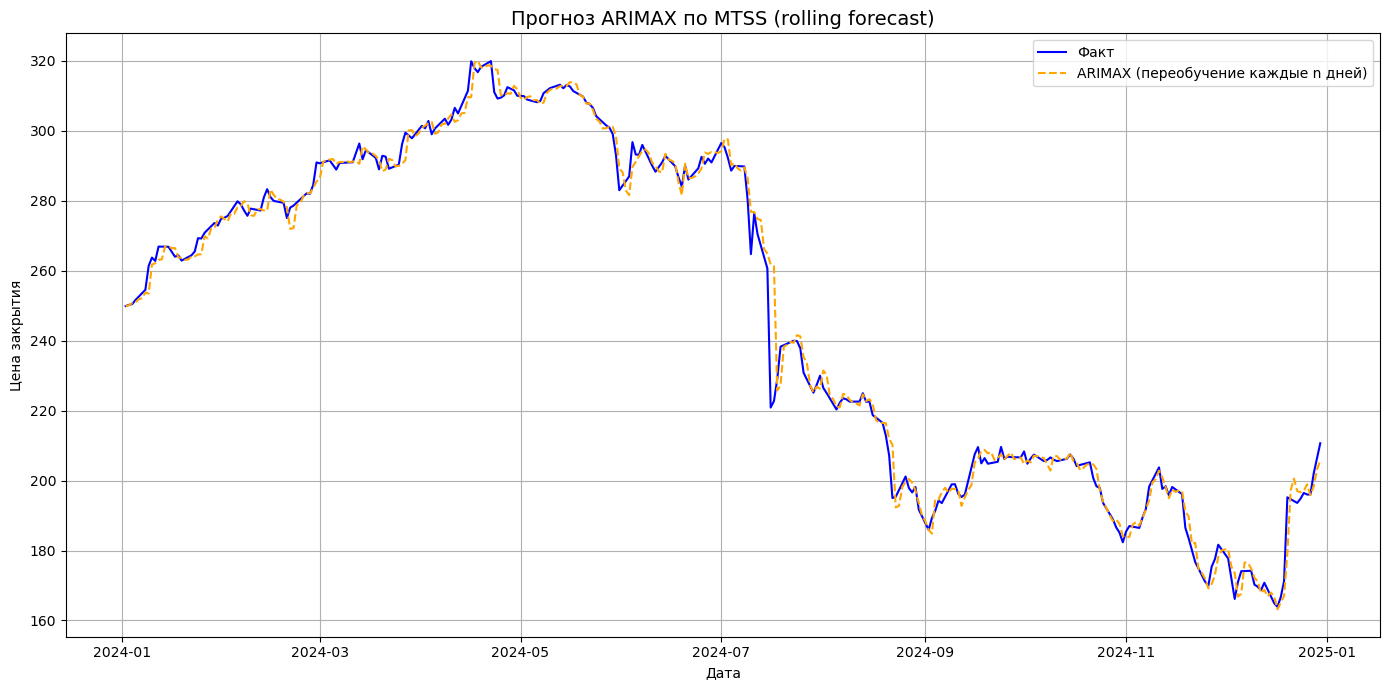

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.stattools import grangercausalitytests
from tqdm import tqdm
import time
import warnings

warnings.filterwarnings('ignore')

# === Загрузка данных ===
df = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/mtss_merged_data.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]

# === Целевая и экзогенные переменные ===
target = "Stock Close"
best_features = ["IMOEX Close", "MOEXOG Close", "CNY Rate"]
best_features = [f for f in best_features if f in df.columns]

df[best_features] = df[best_features].interpolate().ffill()
df.dropna(inplace=True)

# === Лаги через Грейнджера ===
optimal_lags = {}
for feature in best_features:
    try:
        result = grangercausalitytests(df[[target, feature]].dropna(), maxlag=10, verbose=False)
        p_values = [result[i+1][0]['ssr_ftest'][1] for i in range(10)]
        optimal_lag = np.argmin(p_values) + 1
        optimal_lags[feature] = optimal_lag
    except Exception:
        continue

# === Создание лагов ===
def create_lags(data, lags_dict):
    data_copy = data.copy()
    for feature, lag in lags_dict.items():
        for l in range(1, lag + 1):
            data_copy[f'{feature}_lag{l}'] = data_copy[feature].shift(l)
    return data_copy.dropna()

df_lagged = create_lags(df, optimal_lags)

# === Train/Test split ===
split_idx = int(len(df_lagged) * 0.75)
train_lagged = df_lagged.iloc[:split_idx]
test_lagged = df_lagged.iloc[split_idx:]

y_train = train_lagged[target]
X_train = train_lagged.drop(columns=[target])
y_test = test_lagged[target]
X_test = test_lagged.drop(columns=[target])

# === Rolling forecast ===
forecast_list = []
n_days = min(optimal_lags.values())

print("🔄 Rolling forecast начат...")
start_time = time.time()

for i in tqdm(range(0, len(X_test), n_days), desc="Прогнозирование", unit="шаг"):
    end_i = min(i + n_days, len(X_test))
    if end_i <= i:
        break

    current_y_train = pd.concat([y_train, y_test.iloc[:i]])
    current_X_train = pd.concat([X_train, X_test.iloc[:i]])
    current_X_forecast = X_test.iloc[i:end_i]

    print(f"📍 Итерация {i}-{end_i} | Дата: {y_test.index[i].date()}")

    optimal_arima = auto_arima(current_y_train, exogenous=current_X_train, seasonal=False, d=1,
                               trace=False, stepwise=True, suppress_warnings=True, max_p=3, max_q=3)

    model = SARIMAX(current_y_train, exog=current_X_train, order=optimal_arima.order)
    model_fit = model.fit(maxiter=500, disp=False)

    preds = model_fit.forecast(steps=len(current_X_forecast), exog=current_X_forecast)
    forecast_list.extend(preds)

elapsed_time = time.time() - start_time
print(f"✅ Rolling прогноз завершён за {elapsed_time:.1f} секунд.")

# === Сбор результатов ===
forecast_df = pd.DataFrame({
    'Date': y_test.index[:len(forecast_list)],
    'Actual Stock Close': y_test.values[:len(forecast_list)],
    'Forecast Stock Close': forecast_list
}).set_index('Date')

# === Метрики ===
mae = mean_absolute_error(forecast_df['Actual Stock Close'], forecast_df['Forecast Stock Close'])
rmse = np.sqrt(mean_squared_error(forecast_df['Actual Stock Close'], forecast_df['Forecast Stock Close']))
mape = np.mean(np.abs((forecast_df['Actual Stock Close'] - forecast_df['Forecast Stock Close']) / forecast_df['Actual Stock Close'])) * 100

print(f"\n📊 Оценка качества прогноза по MTSS:")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"MAPE = {mape:.2f}%")

# === Визуализация ===
plt.figure(figsize=(14, 7))
plt.plot(forecast_df.index, forecast_df['Actual Stock Close'], label='Факт', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast Stock Close'], label='ARIMAX (переобучение каждые n дней)', color='orange', linestyle='--')
plt.title('Прогноз ARIMAX по MTSS (rolling forecast)', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


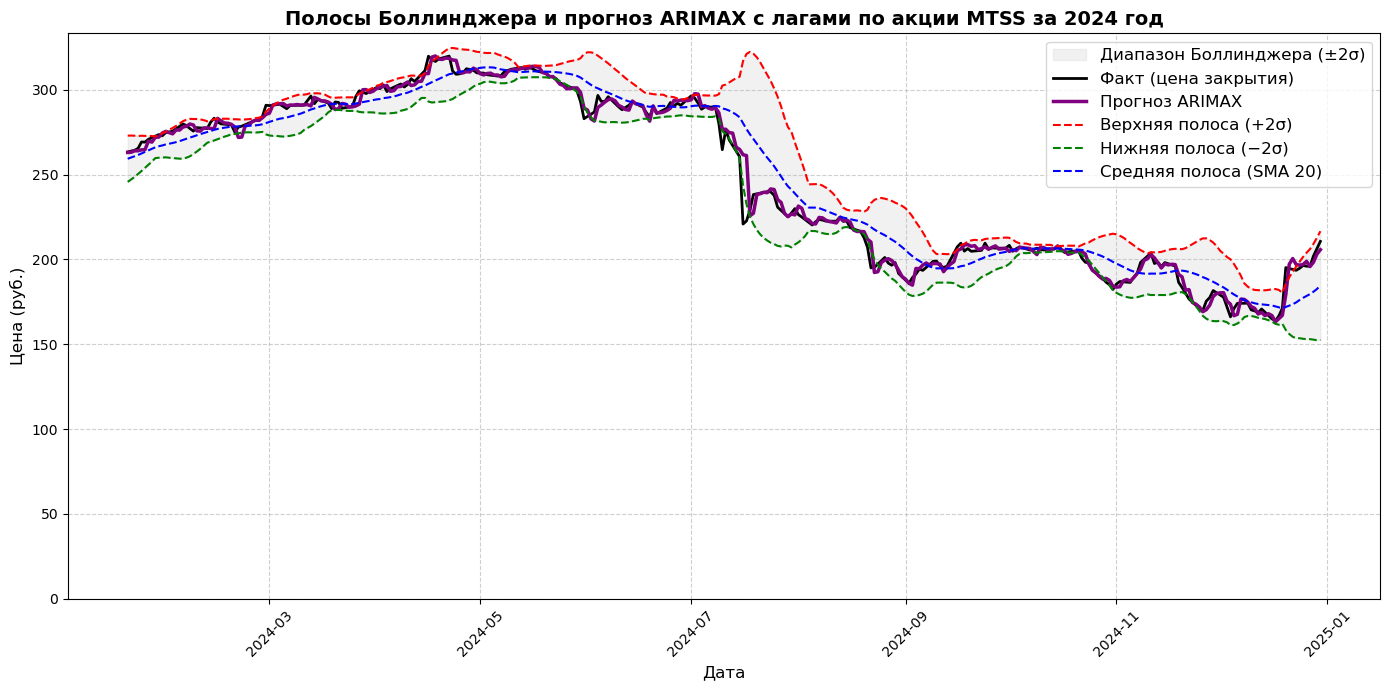

In [5]:
# === Полосы Боллинджера и прогноз ARIMAX с лагами (2024 год) ===

# Отбор данных за 2024 год
df_boll = df.loc["2024-01-01":"2024-12-31"].copy()
df_boll["close"] = df_boll["Stock Close"]

# Расчёт полос Боллинджера
df_boll["bollinger_mid"] = df_boll["close"].rolling(window=20).mean()
df_boll["bollinger_std"] = df_boll["close"].rolling(window=20).std()
df_boll["bollinger_upper"] = df_boll["bollinger_mid"] + 2 * df_boll["bollinger_std"]
df_boll["bollinger_lower"] = df_boll["bollinger_mid"] - 2 * df_boll["bollinger_std"]
df_boll.dropna(subset=["bollinger_upper", "bollinger_lower"], inplace=True)

# Прогноз ARIMAX как Series
forecast_series = forecast_df["Forecast Stock Close"]

# Общий индекс для визуализации
common_index = df_boll.index.intersection(forecast_series.index)

# Подготовка данных
forecast_for_boll = forecast_series.loc[common_index]
actual_for_boll = forecast_df["Actual Stock Close"].loc[common_index]
upper = df_boll["bollinger_upper"].loc[common_index]
lower = df_boll["bollinger_lower"].loc[common_index]
mid = df_boll["bollinger_mid"].loc[common_index]

# === Визуализация ===
plt.figure(figsize=(14, 7))

# Диапазон Боллинджера
plt.fill_between(common_index, lower, upper, color="lightgray", alpha=0.3, label="Диапазон Боллинджера (±2σ)")

# Фактическая цена
plt.plot(actual_for_boll.index, actual_for_boll, label="Факт (цена закрытия)", color="black", linewidth=2)

# Прогноз ARIMAX
plt.plot(forecast_for_boll.index, forecast_for_boll, label="Прогноз ARIMAX", color="purple", linewidth=2.5)

# Полосы
plt.plot(upper.index, upper, label="Верхняя полоса (+2σ)", color="red", linestyle="--", linewidth=1.5)
plt.plot(lower.index, lower, label="Нижняя полоса (−2σ)", color="green", linestyle="--", linewidth=1.5)
plt.plot(mid.index, mid, label="Средняя полоса (SMA 20)", color="blue", linestyle="--", linewidth=1.5)

# Оформление
plt.title("Полосы Боллинджера и прогноз ARIMAX с лагами по акции MTSS за 2024 год", fontsize=14, fontweight="bold")
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Цена (руб.)", fontsize=12)
plt.ylim(bottom=0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
